In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("../Data/medical_no_show.csv")

In [51]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Preprocessing Data

1) Feature Engineering
2) Dropping useless features
3) Type conversion of features
4) X/y separation
5) Train/test split
6) Scaling continuous features

### Feature Engineering

Conversion of ScheduledDay and AppointmentDay to the datetime format. Creating a new feature leadTimedays accounting for the  number of days paintient got between scheduling and appointment. Converting 
Weekday into number.

In [52]:

data = data.sort_values(by=["PatientId", "ScheduledDay"])

Converting the Noshow feautre from yes/no to 1/0

In [53]:
data["No-show"] = data['No-show'].map({'Yes': 1, 'No': 0})

In [ ]:

# Convert 'No-show' to numeric: 1 = No-show, 0 = Showed up
data['NoShowBinary'] = data['No-show'].map({'Yes': 1, 'No': 0})

# Count past appointments (i.e., index of each patient's row)
data['past_appointments'] = data.groupby('PatientId').cumcount()

In [55]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,NoShowBinary,past_appointments
100517,39217.84439,5751990,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,0,0,0,0,NaN,0
105430,43741.75652,5760144,M,2016-06-01T14:22:58Z,2016-06-01T00:00:00Z,39,MARIA ORTIZ,0,0,1,0,0,0,0,NaN,0
3950,93779.52927,5712759,F,2016-05-18T09:12:29Z,2016-05-18T00:00:00Z,33,CENTRO,0,0,0,0,0,0,0,NaN,0
73303,141724.16655,5637648,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,0,0,0,0,NaN,0
73228,537615.28476,5637728,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,0,0,1,0,NaN,0


In [56]:
data['past_no_shows'] = (
    data
      .groupby('PatientId')['NoShowBinary']
      .transform(lambda x: x.shift().cumsum().fillna(0))
)

In [ ]:
data['patient_no_show_rate'] = (
    data['past_no_shows'] 
    / data['past_appointments'].replace(0, np.nan)
).fillna(0)
# Drop helper columns if not needed
data.drop(['NoShowBinary', 'past_no_shows'], axis=1, inplace=True)

In [58]:
data["ScheduledDay"]   = pd.to_datetime(data["ScheduledDay"])
data["AppointmentDay"] = pd.to_datetime(data["AppointmentDay"])
data["LeadTimeDays"]   = (data["AppointmentDay"] - data["ScheduledDay"]).dt.days.clip(lower=0)
data["Weekday"]        = data["AppointmentDay"].dt.weekday   # 0=Mon … 6=Sun

In [ ]:

data['ScheduledDay']   = pd.to_datetime(data['ScheduledDay'], infer_datetime_format=True)
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'], infer_datetime_format=True)

data['LeadTimeDays'] = (
    data['AppointmentDay'].dt.normalize()
    - data['ScheduledDay'].dt.normalize()
).dt.days.clip(lower=0)

data['Weekday'] = data['AppointmentDay'].dt.dayofweek

data.drop(['ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)


/tmp/ipykernel_7264/1792855129.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['ScheduledDay']   = pd.to_datetime(data['ScheduledDay'], infer_datetime_format=True)
/tmp/ipykernel_7264/1792855129.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'], infer_datetime_format=True)


IDs are not expected to have any sort of relationship with NoShow so they are dropped.

In [60]:
#Drop useless ID columns
data = data.drop(columns=["PatientId", "AppointmentID"])

In [ ]:
# Find the top 10 neighbourhoods
top10 = data["Neighbourhood"].value_counts().nlargest(10).index

#  Group the rest as “Other”
data["Nbhd_grouped"] = data["Neighbourhood"].where(
    data["Neighbourhood"].isin(top10),
    other="Other"
)

#  One‐hot encode with dtype=int (pandas ≥1.5.0)
nbhd_dummies = pd.get_dummies(
    data["Nbhd_grouped"], 
    prefix="Nbhd", 
    dtype=int
)

#  Drop the original and concat back
data = pd.concat(
    [data.drop(columns=["Neighbourhood", "Nbhd_grouped"]), 
     nbhd_dummies],
    axis=1
)

In [62]:
# map “F” → 1, “M” → 0
data["Gender_bin"] = (data["Gender"] == "F").astype(int)
data = data.drop(columns=["Gender"])

In [63]:
#Split out X/y
feature_cols = [c for c in data.columns if c != "No-show"]
X = data[feature_cols]
y = data["No-show"]

In [64]:
# Train/val split 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Scale 
cont_cols = ["Age", "LeadTimeDays","patient_no_show_rate", "SMS_received"]
scaler = StandardScaler().fit(X_train[cont_cols])
X_train[cont_cols] = scaler.transform(X_train[cont_cols])
X_val[cont_cols]   = scaler.transform(X_val[cont_cols])

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110527 entries, 100517 to 76224
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Age                     110527 non-null  int64  
 1   Scholarship             110527 non-null  int64  
 2   Hipertension            110527 non-null  int64  
 3   Diabetes                110527 non-null  int64  
 4   Alcoholism              110527 non-null  int64  
 5   Handcap                 110527 non-null  int64  
 6   SMS_received            110527 non-null  int64  
 7   past_appointments       110527 non-null  int64  
 8   patient_no_show_rate    110527 non-null  float64
 9   LeadTimeDays            110527 non-null  int64  
 10  Weekday                 110527 non-null  int32  
 11  Nbhd_BONFIM             110527 non-null  int64  
 12  Nbhd_CENTRO             110527 non-null  int64  
 13  Nbhd_ITARARÉ            110527 non-null  int64  
 14  Nbhd_JARDIM CAMBURI  

### Timer decorator

In [67]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        duration = end - start
        if args and hasattr(args[0], '__dict__'):
            setattr(args[0], f'{func.__name__}_time', duration)
        print(f"Function '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

## Model

In [68]:
# LAYER interface -->
# We will use to this create two types of layers :
# Dense and Activation
class Layer:
    def forward(self, inputs):
        raise NotImplementedError # all interface methods are implemented in the parent class

    def backward(self, grad_output, learning_rate):
        raise NotImplementedError # all interface methods are implemented in the parent class

In [69]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01):

        # Xavier initialization
        limit = np.sqrt(6 / (input_units + output_units))
        self.W = np.random.uniform(-limit, limit, (input_units, output_units))
        self.b = np.zeros((1, output_units))
        self.learning_rate = learning_rate

        # placeholders for backward pass
        self.inputs = None
        self.grad_W = None
        self.grad_b = None

    def forward(self, inputs):
        self.inputs = inputs  # cache for backward
        return np.dot(inputs, self.W) + self.b #return prediction

    def backward(self, grad_output, learning_rate=None):
        if learning_rate is None:
            learning_rate = self.learning_rate #use the initialized learning rate itself
        
        # gradients
        self.grad_W = np.dot(self.inputs.T, grad_output) / self.inputs.shape[0]
        self.grad_b = np.mean(grad_output, axis=0, keepdims=True)

        # gradient w.r.t. inputs for previous layer
        grad_inputs = np.dot(grad_output, self.W.T) #sent recursively to the previous layer

        # update weights (batch gradient descent)
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b
        return grad_inputs

In [70]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime # the derivative function
        self.inputs = None

    def forward(self, inputs):
        self.inputs = inputs
        return self.activation(inputs) #given x calculate f(x)

    def backward(self, grad_output, learning_rate=None):
        return grad_output * self.activation_prime(self.inputs)

In [71]:
# common activations

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, loss_grad):
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def compute_loss(self, y_pred, y_true):
        # Binary cross-entropy
        m = y_true.shape[0]
        eps = 1e-8
        loss = -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
        # gradient of loss w.r.t. predictions
        grad = (y_pred - y_true) / (y_true * (1 - y_true) + eps) / m
        return loss, grad

    
    @timer
    def fit(self, X, y, epochs=1000, learning_rate=0.01, verbose=True):
        y = y.reshape(-1, 1)
        for layer in self.layers:
            if isinstance(layer, Dense):
                layer.learning_rate = learning_rate

        for epoch in range(1, epochs+1):
            # forward
            y_pred = self.forward(X)
            # loss
            loss, loss_grad = self.compute_loss(y_pred, y)
            # backward
            self.backward(loss_grad)
            if verbose and epoch % (epochs // 10) == 0:
                print(f"Epoch {epoch}/{epochs}, loss: {loss:.4f}")

    def predict(self, X, threshold=0.5):
        y_prob = self.forward(X)
        return (y_prob > threshold).astype(int)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)
import matplotlib.pyplot as plt

X_train_np = X_train.values    
X_val_np   = X_val.values
y_train_np = y_train.values.reshape(-1, 1)  
y_val_np   = y_val.values.reshape(-1, 1)


nn = NeuralNetwork()
nn.add(Dense(input_units=23, output_units=32))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(input_units=32, output_units=16))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(input_units=16, output_units=1))
nn.add(Activation(sigmoid, sigmoid_prime))

nn.fit(X_train_np, y_train_np, epochs=5000, learning_rate=0.01, verbose=True)




Epoch 500/5000, loss: 0.4529
Epoch 1000/5000, loss: 0.4489
Epoch 1500/5000, loss: 0.4466
Epoch 2000/5000, loss: 0.4446
Epoch 2500/5000, loss: 0.4429
Epoch 3000/5000, loss: 0.4411
Epoch 3500/5000, loss: 0.4396
Epoch 4000/5000, loss: 0.4387
Epoch 4500/5000, loss: 0.4379
Epoch 5000/5000, loss: 0.4371
Function 'fit' took 518.4584 seconds


Accuracy:  0.5993
Precision: 0.3094
Recall:    0.7988
F1-score:  0.4461
PR-AUC:    0.3588
Confusion Matrix:
[[9683 7959]
 [ 898 3566]]


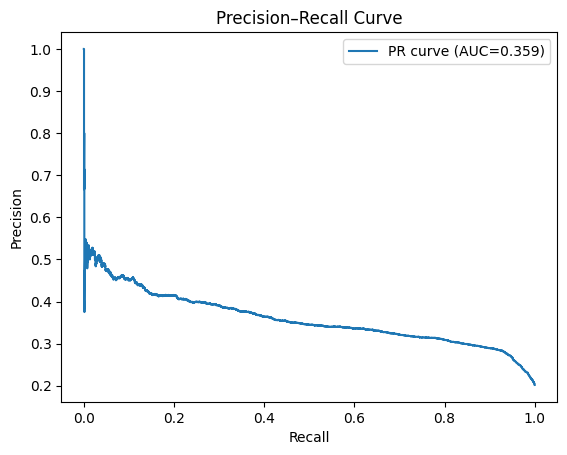

In [ ]:

y_prob_val = nn.forward(X_val_np).reshape(-1)        
y_pred_val = (y_prob_val > 0.163).astype(int)   
acc   = accuracy_score(y_val_np, y_pred_val)
prec  = precision_score(y_val_np, y_pred_val)
rec   = recall_score   (y_val_np, y_pred_val)
f1    = f1_score       (y_val_np, y_pred_val)
pr_auc = average_precision_score(y_val_np, y_prob_val)
cm    = confusion_matrix(y_val_np, y_pred_val)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print("Confusion Matrix:")
print(cm)

precision, recall, thresholds = precision_recall_curve(y_val_np, y_prob_val)
plt.figure()
plt.plot(recall, precision, label=f"PR curve (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


### Best Threshold for maximizing F1

In [75]:
from sklearn.metrics import f1_score, precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_val_np, y_prob_val)

# Compute F1 at each threshold and pick the best
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold: {best_thresh:.3f}, F1: {f1_scores[best_idx]:.4f}")

# Apply it
y_pred_best = (y_prob_val > best_thresh).astype(int)
print("F1 at best thresh:", f1_score(y_val_np, y_pred_best))


Best threshold: 0.172, F1: 0.4476
F1 at best thresh: 0.4474615533105978
